In [2]:
import pandas as pd
import os

# import all the trips files and store them together in a single dataframe
trips_folder = './Data/Trips/'

for idx, trips_day in enumerate(os.listdir(trips_folder)):
    # get full directory
    dir = trips_folder + trips_day

    # read csv
    df = pd.read_csv(dir, sep=';')

    # add dataframes together
    if idx == 0:
        trips_df = df
    else:
        trips_df = pd.concat([trips_df, df])

# show
trips_df

,Date of departure,Train number,Relation,Railway operator,Departure line,Actual arrival time,Actual departure time,Planned arrival time,Planned departure time,Delay at arrival,Delay at departure,Relation direction,Stopping place,Arrival line,Planned arrival date,Planned departure date,Actual arrival date,Actual departure date
0,2025-09-22,3605,IC 29,SNCB/NMBS,36,06:28:04,06:28:04,06:25:00,06:25:00,184.0,184.0,IC 29: GENT-SINT-PIETERS -> GENK,SCHAARBEEK,36,2025-09-22,2025-09-22,2025-09-22,2025-09-22
1,2025-09-22,3605,IC 29,SNCB/NMBS,36N,06:34:58,06:34:58,06:32:00,06:32:00,178.0,178.0,IC 29: GENT-SINT-PIETERS -> GENK,KORTENBERG,36N,2025-09-22,2025-09-22,2025-09-22,2025-09-22
2,2025-09-22,3605,IC 29,SNCB/NMBS,36,06:41:40,06:43:28,06:39:00,06:42:00,160.0,88.0,IC 29: GENT-SINT-PIETERS -> GENK,LEUVEN,36N,2025-09-22,2025-09-22,2025-09-22,2025-09-22
3,2025-09-22,3605,IC 29,SNCB/NMBS,36,06:50:53,06:50:53,06:49:00,06:49:00,113.0,113.0,IC 29: GENT-SINT-PIETERS -> GENK,VERTRIJK,36,2025-09-22,2025-09-22,2025-09-22,2025-09-22
4,2025-09-22,3605,IC 29,SNCB/NMBS,36,07:02:49,07:02:49,07:00:00,07:00:00,169.0,169.0,IC 29: GENT-SINT-PIETERS -> GENK,EZEMAAL,36,2025-09-22,2025-09-22,2025-09-22,2025-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40781,2025-09-28,9426,EURST,THI-FACT,0/2,10:30:37,10:30:37,10:31:00,10:31:00,-23.0,-23.0,EURST: KOLN HBF -> PARIS-NORD,BRUSSEL-CENTRAAL,0/2,2025-09-28,2025-09-28,2025-09-28,2025-09-28
40782,2025-09-28,9426,EURST,THI-FACT,0/2,10:31:35,10:31:35,10:33:00,10:33:00,-85.0,-85.0,EURST: KOLN HBF -> PARIS-NORD,BRUSSEL-KAPELLEKERK,0/2,2025-09-28,2025-09-28,2025-09-28,2025-09-28
40783,2025-09-28,9426,EURST,THI-FACT,1,11:00:41,11:00:41,10:52:00,10:52:00,521.0,521.0,EURST: KOLN HBF -> PARIS-NORD,HALLE,1,2025-09-28,2025-09-28,2025-09-28,2025-09-28
40784,2025-09-28,9887,TGV,SNCB/NMBS,NaN,13:12:47,NaN,11:03:00,NaN,7788.0,NaN,TGV: MARSEILLE-SAINT-CHARLES -> BRUSSEL-ZUID,BRUSSEL-ZUID,96N,2025-09-28,NaN,2025-09-28,NaN


In [13]:
trips_df['Planned departure time'] = pd.to_datetime(trips_df['Planned departure time'])
trips_df['Actual departure time'] = pd.to_datetime(trips_df['Actual departure time'])

trips_sorted = trips_df.sort_values(['Stopping place', 'Planned departure time']).reset_index(drop=True)

trips_sorted
trips_sorted['propagated_delay'] = 0
delay_threshold = 5 * 60  # seconden

for station, group in trips_sorted.groupby('Stopping place'):
    prev_delay = None
    for idx, row in group.iterrows():
        if prev_delay is not None:
            # If previous train delay exceeds threshold, mark current train as potentially affected
            if prev_delay > delay_threshold and row['Delay at departure'] > 0:
                trips_sorted.loc[idx, 'propagated_delay'] = 1
        prev_delay = row['Delay at departure']

propagations = trips_sorted['propagated_delay'].sum()
print("Trains affected by previous delay:", propagations)

station_summary = trips_sorted.groupby('Stopping place')['propagated_delay'].sum().sort_values(ascending=False)
print(station_summary.head(10))


Trains affected by previous delay: 35855
Stopping place
BRUSSEL-CENTRAAL       1195
BRUSSEL-CONGRES         836
BRUSSEL-NOORD           777
BRUSSEL-KAPELLEKERK     752
BRUSSEL-ZUID            681
SCHAARBEEK              465
ANTWERPEN-BERCHEM       452
HALLE                   353
MECHELEN                340
LIEGE-GUILLEMINS        292
Name: propagated_delay, dtype: int64


In [21]:
station_summary

Stopping place
BRUSSEL-CENTRAAL             1195
BRUSSEL-CONGRES               836
BRUSSEL-NOORD                 777
BRUSSEL-KAPELLEKERK           752
BRUSSEL-ZUID                  681
                             ... 
SCHAARBEEK-NOS                  0
RONET-FORMATION                 0
GENT-SINT-PIETERS-BUNDELS       0
BAMBRUGGE                       0
AALST-KERREBROEK                0
Name: propagated_delay, Length: 616, dtype: int64

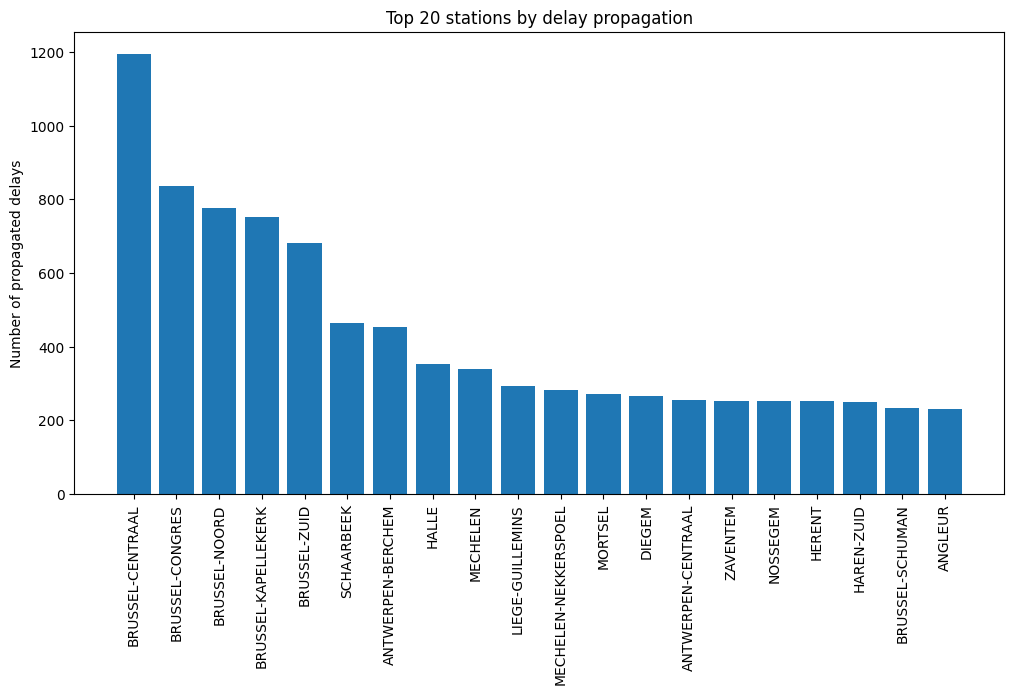

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(station_summary.head(20).index, station_summary.head(20).values)
plt.ylabel("Number of propagated delays")
plt.title("Top 20 stations by delay propagation")
plt.xticks(rotation=90)
plt.show()